In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [211]:
# EM Gaussian profile, emparams in the format [scale, center, size]
def em_prfl(r, emparams):
    return emparams[0]*np.exp(-np.power(r - emparams[1],2)/emparams[2])

# right-hand side of ODE from "Axion dark matter, solitons and the cusp–core problem" Appendix A
def f(r, X, emparams):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0] - em_prfl(r, emparams)
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# interval of solution and number of steps
ri, rf, dr = 0, 20, 0.1
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# single step of RK4
def rk4step(r, X, emparams):
    k1 = dr*f(r, X, emparams)
    k2 = dr*f(r + dr/2, X + k1/2, emparams)
    k3 = dr*f(r + dr/2, X + k2/2, emparams)
    k4 = dr*f(r + dr, X + k3, emparams)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

def rk4(Xbc, emparams):
    # initialize the arrays
    Xs = np.zeros((4, steps))

    # boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # perform RK4
    bpoint = 0
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1], emparams)
    
        # the breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if Xs[..., step][0] > Xs[..., step - 1][0] or Xs[..., step][0] < 0:
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold, emparams):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step, emparams)

    # If the breakpoint happens for higher values of r, keep the new solution (ground state should have breakpoint at infty)
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol(emparams):
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    # count avoids the code 'getting stuck' for large periods of time
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint, emparams)
        if mcs[0]:
            bpoint = mcs[1]
        else:
            phi0 = phi0old
            count += 1
            
        if count > 100:
            count = 0
            step_stdev = step_stdev/10

        if bpoint == steps - 1:
            return phi0, bpoint

    return phi0, bpoint

# def find_bestsol(emparams):
#     # run find_sol ntimes times, the 'best solution' will have the largest value of bpoint
#     bpoints, phis, ntimes = [], [], 1
#     for i in np.arange(ntimes):
#         phi, bpoint = find_sol(emparams)
#         phis.append(phi)
#         bpoints.append(bpoint)

#     return phis[bpoints.index(max(bpoints))], np.array(zip(phis, bpoints))

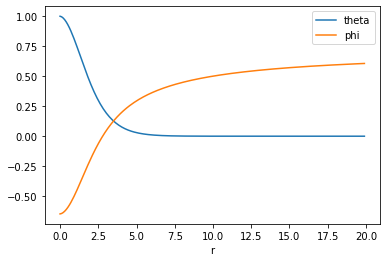

In [212]:
# Plotting best solution, emparams in the format [scale, center, size]
emparams = [0, 0, 0.1]
phi0_plt = find_bestsol(emparams)[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt, emparams)

plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.plot(rinterv[:bpoint], Xs[2].T[:bpoint], label = "phi")
plt.xlabel("r")
plt.legend();